In [1]:
import glob
import json
import pandas as pd
import tensorflow as tf
import spacy
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Flatten, Concatenate, TimeDistributed, Bidirectional, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow import TensorShape
import tensorflow_addons as tfa
from langdetect import detect
import tensorflow_datasets as tfds
import itertools

In [2]:
%%time

ds = tfds.load('cnn_dailymail', split='train', as_supervised=True)
h,a = [],[]

for article, highlights in ds:  
    h.append(str(highlights.numpy()))  
    a.append(str(article.numpy()))
cnn = pd.DataFrame(list(zip(a, h)), 
               columns =['article', 'highlights']) 

CPU times: user 2min 17s, sys: 12.1 s, total: 2min 29s
Wall time: 1min 11s


In [3]:
#feed data slowly to model. 

In [4]:
%%time

cnn.article = cnn.article.apply(lambda x : x.rsplit(maxsplit=len(x.split())-70)[0])
cnn.highlights = cnn.highlights.apply(lambda x : x.rsplit(maxsplit=len(x.split())-50)[0])

CPU times: user 20.2 s, sys: 0 ns, total: 20.2 s
Wall time: 20.2 s


In [5]:
cnn['len_bt'] = cnn.article.map(lambda x: len(x.split(" ")))
cnn['len_ab'] = cnn.highlights.map(lambda x: len(x.split(" ")))
#cnn.query('len_bt <= 1000 and len_ab <= 30', inplace = True)
cnn = cnn[:10000]

In [6]:
cnn.describe()

,len_bt,len_ab
count,10000.000000,10000.000000
mean,70.008200,20.265300
std,1.715234,23.949265
min,1.000000,1.000000
25%,70.000000,1.000000
50%,70.000000,1.000000
75%,70.000000,50.000000
max,83.000000,53.000000


In [7]:
cnn.head()

,article,highlights,len_bt,len_ab
0,"b""By . Associated Press . PUBLISHED: . 14:11 E...",b'Bishop,70,1
1,b'(CNN) -- Ralph Mata was an internal affairs ...,b'Criminal,70,1
2,"b""A drunk driver who killed a young woman in a...","b""Craig Eccleston-Todd, 27, had drunk at least...",70,50
3,"b""(CNN) -- With a breezy sweep of his pen Pres...","b""Nina dos Santos says Europe must be ready to...",70,50
4,"b""Fleetwood are the only team still to have a ...",b'Fleetwood top of League One after 2-0 win at...,70,50


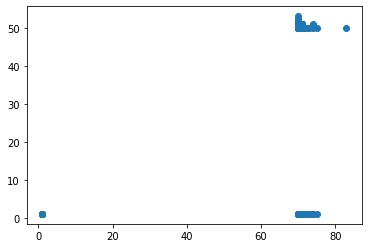

In [8]:
plt.scatter(cnn.len_bt,cnn.len_ab)

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
def clean_text(bodytext):
    cleaned = list()
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for word in bodytext:
        words = str(word)       
        words = words.lower()
        words = words.translate(table)
        words = re_print.sub('', words) 
        if words.isalpha() == True:
            cleaned.append(words)
    cleaned.insert(0, '<start>')
    cleaned.append('<end>')
    return cleaned

In [11]:
%%time

nlp = spacy.load("en_core_web_lg")
bt_vector = list()
bt_list = []
ab_list = []
for i in range(len(cnn)):
    bodytext = nlp(cnn.iloc[i].article)
    bt_clean = clean_text(bodytext)
    bt_list.append(bt_clean)
    
    abstract = nlp(cnn.iloc[i].highlights)
    ab_clean = clean_text(abstract)
    ab_list.append(ab_clean)
com_list = ab_list + bt_list
    #c_papers.append(papers)
bt_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
bt_tokenizer.fit_on_texts(com_list)
data_bt = bt_tokenizer.texts_to_sequences(bt_list)
data_ab = bt_tokenizer.texts_to_sequences(ab_list)

longest_seq = max(max([len(x) for x in data_bt]), max([len(x) for x in data_ab]))
#x_voc_size = max([len(x) for x in data_bt])#, max([len(x) for x in data_ab]))
#y_voc_size = max([len(y) for y in data_ab])
data_bt = tf.keras.preprocessing.sequence.pad_sequences(data_bt,padding='post', maxlen = longest_seq)
data_ab = tf.keras.preprocessing.sequence.pad_sequences(data_ab,padding='post', maxlen = longest_seq) 

CPU times: user 5min 20s, sys: 0 ns, total: 5min 20s
Wall time: 5min 20s


In [12]:
def max_len(tensor):
    #print( np.argmax([len(t) for t in tensor]))
    return max( len(t) for t in tensor)

In [13]:

X_train,  X_test, Y_train, Y_test = train_test_split(data_bt,data_ab,test_size=0.2)
BATCH_SIZE = 2
BUFFER_SIZE = len(X_train)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dims = 256
rnn_units = 64
dense_units = 64
Dtype = tf.float32
#dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


a = bt_tokenizer.word_index
print(list(a.keys())[list(a.values()).index(9326)])

In [14]:
vocab_size = len(bt_tokenizer.word_index)+1  
vocab_size

46921

In [15]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)

In [16]:
def initialize_initial_state():
        return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]
encoder_initial_cell_state = initialize_initial_state()

In [17]:
#ENCODER
class EncoderNetwork(tf.keras.Model):
    def __init__(self,input_vocab_size,embedding_dims, rnn_units ):
        super().__init__()
        self.encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab_size,
                                                           output_dim=embedding_dims)
        self.encoder_rnnlayer = tf.keras.layers.LSTM(rnn_units,return_sequences=True, 
                                                     return_state=True )
    
#DECODER
class DecoderNetwork(tf.keras.Model):
    def __init__(self,output_vocab_size, embedding_dims, rnn_units):
        super().__init__()
        self.decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab_size,
                                                           output_dim=embedding_dims) 
        self.dense_layer = tf.keras.layers.Dense(output_vocab_size)
        self.decoder_rnncell = tf.keras.layers.LSTMCell(rnn_units)
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = self.build_attention_mechanism(dense_units,None,BATCH_SIZE*[longest_seq]) 
        self.rnn_cell =  self.build_rnn_cell(BATCH_SIZE)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler= self.sampler,
                                                output_layer=self.dense_layer)

    def build_attention_mechanism(self, units,memory, memory_sequence_length):
        return tfa.seq2seq.LuongAttention(units, memory = memory, 
                                          memory_sequence_length=memory_sequence_length)
        #return tfa.seq2seq.BahdanauAttention(units, memory = memory, memory_sequence_length=memory_sequence_length)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size ):
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, self.attention_mechanism,
                                                attention_layer_size=dense_units)
        return rnn_cell
    
    def build_decoder_initial_state(self, batch_size, encoder_state,Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 
        return decoder_initial_state

encoderNetwork = EncoderNetwork(vocab_size,embedding_dims, rnn_units)
decoderNetwork = DecoderNetwork(vocab_size,embedding_dims, rnn_units)
optimizer = tf.keras.optimizers.Adam()

In [18]:
def loss_function(y_pred, y):
   
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask* loss
    loss = tf.reduce_mean(loss)
    return loss

def train_step(input_batch, output_batch,encoder_initial_cell_state):
    #initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
        a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                        initial_state =encoder_initial_cell_state)

        #[last step activations,last memory_state] of encoder passed as input to decoder Network
        
         
        # Prepare correct Decoder input & output sequence data
        decoder_input = output_batch[:,:-1] # ignore <end>
        #compare logits with timestepped +1 version of decoder_input
        decoder_output = output_batch[:,1:] #ignore <start>


        # Decoder Embeddings
        decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

        #Setting up decoder memory from encoder output and Zero State for AttentionWrapperState
        decoderNetwork.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                           encoder_state=[a_tx, c_tx],
                                                                           Dtype=tf.float32)
        
        #BasicDecoderOutput        
        outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=BATCH_SIZE*[longest_seq-1])

        logits = outputs.rnn_output
        #Calculate loss

        loss = loss_function(logits, decoder_output)

    #Returns the list of all layer variables / weights.
    variables = encoderNetwork.trainable_variables + decoderNetwork.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    #grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss


In [19]:
def generator(X_train, Y_train, batch_size):
    num_samples = len(X_train)
    print(num_samples)
    while True:
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            yield X_train[offset:offset+batch_size], Y_train[offset:offset+batch_size]
    
train_samples = generator(X_train, Y_train, batch_size = 12)


In [22]:
dataset = tf.data.Dataset.from_tensor_slices(next(train_samples)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [23]:
epochs = 100
for i in range(1, epochs+1):

    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0

    for ( batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss
        if (batch+1)%2 == 0:
            print("total loss: {} epoch {} batch {} ".format(batch_loss.numpy(), i, batch+1))

total loss: 3.4760000705718994 epoch 1 batch 2 
total loss: 3.4754750728607178 epoch 1 batch 4 
total loss: 3.409573554992676 epoch 1 batch 6 
total loss: 0.261798620223999 epoch 2 batch 2 
total loss: 0.26156753301620483 epoch 2 batch 4 
total loss: 6.333439350128174 epoch 2 batch 6 
total loss: 0.2604919970035553 epoch 3 batch 2 
total loss: 3.482128620147705 epoch 3 batch 4 
total loss: 3.3008999824523926 epoch 3 batch 6 
total loss: 3.2071681022644043 epoch 4 batch 2 
total loss: 3.1975204944610596 epoch 4 batch 4 
total loss: 5.736441135406494 epoch 4 batch 6 
total loss: 5.0985941886901855 epoch 5 batch 2 
total loss: 2.490811347961426 epoch 5 batch 4 
total loss: 2.2938127517700195 epoch 5 batch 6 
total loss: 3.863168478012085 epoch 6 batch 2 
total loss: 1.9003880023956299 epoch 6 batch 4 
total loss: 0.14551769196987152 epoch 6 batch 6 
total loss: 0.12727665901184082 epoch 7 batch 2 
total loss: 0.11714531481266022 epoch 7 batch 4 
total loss: 1.5440796613693237 epoch 7 batc

In [25]:
#In this section we evaluate our model on a raw_input converted to german, for this the entire sentence has to be passed
#through the length of the model, for this we use greedsampler to run through the decoder
#and the final embedding matrix trained on the data is used to generate embeddings
input_raw=X_test[0].reshape(1,-1)
# inp_bodytext = nlp(input_raw)
# input_lines = clean_text(inp_bodytext)

# We have a transcript file containing English-German pairs
# Preprocess X
#input_raw = clean_text(input_raw)
#input_lines = [f'{bt_tok} {input_raw}']
# input_sequences = [[bt_tokenizer.word_index[w] for w in line.split()] for line in input_raw]
# input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_raw,
#                                                                maxlen=longest_seq, padding='post')
# inp = tf.convert_to_tensor(input_sequences)

#print("inp", inp.shape)
#print("inp_seq",input_sequences)
#inference_batch_size = input_sequences.shape[0]
encoder_initial_cell_state = [tf.zeros((1, rnn_units)),tf.zeros((1, rnn_units))]
encoder_emb_inp = encoderNetwork.encoder_embedding(input_raw)
a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,initial_state =encoder_initial_cell_state)
# print('a_tx :', a_tx.shape)
# print('c_tx :', c_tx.shape)

start_tokens = tf.fill([1],bt_tokenizer.word_index['<start>'])

end_token = bt_tokenizer.word_index['<end>']

greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

decoder_input = tf.expand_dims([bt_tokenizer.word_index['<start>']]* 1,1)
decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

decoder_instance = tfa.seq2seq.BasicDecoder(cell = decoderNetwork.rnn_cell, sampler = greedy_sampler,
                                            output_layer=decoderNetwork.dense_layer)
decoderNetwork.attention_mechanism.setup_memory(c_tx)
#pass [ last step activations , encoder memory_state ] as input to decoder for LSTM
# print(f"decoder_initial_state = [a_tx, c_tx] : {np.array([a_tx, c_tx]).shape}")
decoder_initial_state = decoderNetwork.build_decoder_initial_state(1,
                                                                   encoder_state=[a_tx, c_tx],
                                                                   Dtype=tf.float32)
# print(f"""
# Compared to simple encoder-decoder without attention, the decoder_initial_state
# is an AttentionWrapperState object containing s_prev tensors and context and alignment vector

# decoder initial state shape: {np.array(decoder_initial_state).shape}
# decoder_initial_state tensor
# {decoder_initial_state}
# """)

# Since we do not know the target sequence lengths in advance, we use maximum_iterations to limit the translation lengths.
# One heuristic is to decode up to two times the source sentence lengths.
maximum_iterations = tf.round(tf.reduce_max(longest_seq)*2)

#initialize inference decoder
decoder_embedding_matrix = decoderNetwork.decoder_embedding.variables[0] 
(first_finished, first_inputs,first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                             start_tokens = start_tokens,
                             end_token=end_token,
                             initial_state = decoder_initial_state)
#print( first_finished.shape)
#print(f"first_inputs returns the same decoder_input i.e. embedding of  {'<start>'} : {first_inputs.shape}")
#print(f"start_index_emb_avg {tf.reduce_sum(tf.reduce_mean(first_inputs, axis=0))}") # mean along the batch

inputs = first_inputs
state = first_state 

predictions = np.empty((1,0), dtype = np.int32)                                                                             
for j in range(maximum_iterations):
    outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
    inputs = next_inputs
    state = next_state
    #print(next_inputs)
    outputs = np.expand_dims(outputs.sample_id,axis = -1)
    predictions = np.append(predictions, outputs, axis = -1)

In [26]:
print("\nSummary:")
for i in range(len(predictions)):
    line = predictions[i,:]
    seq = list(itertools.takewhile( lambda index: index !=2, line))
    print(" ".join( [bt_tokenizer.index_word[w] for w in seq]))


Summary:
<end> <end> <end> <end> <end> <end> <end> the <end> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


In [27]:
cnn.describe()

,len_bt,len_ab
count,10000.000000,10000.000000
mean,70.008200,20.265300
std,1.715234,23.949265
min,1.000000,1.000000
25%,70.000000,1.000000
50%,70.000000,1.000000
75%,70.000000,50.000000
max,83.000000,53.000000
